# Notebook #6 - GraphBLAS overview

Outline:
1. [Graphs and Sparse Matrices](#Graphs-and-Sparse-Matrices)
2. [Whirlwind Tour of the GraphBLAS](#Whirlwind-Tour-of-the-GraphBLAS)
3. [Looking at Code](#Looking-at-Code)
4. [More Resources](#More-Resources)

With observations on pitfalls I've seen for new users.

Note: This **cannot** be even a serious outline of even the high-level pieces of the GraphBLAS.

My intention is a quick, ***opinionated*** tour of the GraphBLAS and its C binding.  Questions, comments, and corrections welcome during the crazy tour.

Other much, much longer tutorials cover a full introduction:
- https://graphblas.org/GraphBLAS-Pointers/#tutorials
- https://github.com/GraphBLAS-Tutorials/SIAM-Tutorial

Also: The GraphBLAS is the product of many other peoples' work over a long, long time.  I'm just a sideline commenter.


## Graphs and Sparse Matrices

These have been buddies for a long, long time.
- Solving sparse systems, computing their spectrum, etc. often rely on graph analysis primitives.
- Spectral graph theories rely on sparse matrix algebra.

First: A quick tour of a few methods for mapping graphs onto sparse matrices.
- Adjacency and variations
- Incidence

### Adjacency Matrices

This is what most people first consider.  The rows and columns of a square matrix $A$ represent the vertices of the graph.  Then an entry $a_{ij}$ holds the value on the **directed** edge from $i$ to $j$.
- Matrix-vector (mxv, vxm) and matrix-matrix (mxm) product gather data from paths $i \rightarrow k \rightarrow j$ in the output's entry for $i \rightarrow j$.
  - Natural mapping to breadth-first search and other path-oriented algorithms.
- Undirected graphs store $i \rightarrow j$ and $j \rightarrow i$, leading to occassional confusion over the number of edges.
  - An entry on the diagonal is a self-loop.  Is that one edge or two?
  
But this is the basis for the rest here and the most commonly used (IMHO).

#### Bipartite Variation

Bipartite graphs in adjacency matrix form would have a block matrix structure: $[0, A; A^T, 0]$.

Often this is compressed to simply representing $A$, where the rows correspond to one side of the graph and columns to the other.

Multi-partite graphs often are broken into multiple such graphs.

This is similar to "optimizing" structured matrices for mxv and mxm.

#### Depth Variation

*Personal* view, not common usage:
- Sometimes you'll encounter algorithms that modify the adjacency matrix to force what appear to be self-loops (adding the identity matrix).
- In my experience, these often are not quite adjacency matrices but a slight variation.  
- The matrix entries encode which vertices can be *reached* in at most a fixed number of edge traversals.  
- The plain identity becomes the edges in at most zero hops.  
- Adjacency plus identity: In two hops.  $A^k$: $k$ hops, used *e.g.* when computing the transitive closure.

### Incidence Matrices

Perhaps the most general and not often seen.
- Rows (typically) represent vertices and columns **edges**.
- Then two vertices $i$ an $j$ connected by edge $e$ are denoted by $a_{ie} = a_{je} = 1$ for an undirected graph.
- Directed graphs use signed edges.  
- *Hypergraphs* have more than two entries in a column denoting that *all* the marked vertices are in the same hyperedge.

This is terribly flexible.  Other forms can be computed by interpretations of $A A^{T}$ (adjacency), $A^T A$ (line graph), and more.

Incidence matrices appear in mathematic programming (linear optimizaton) formulations, non-backtracking walks, and algorithms in increasing levels of generality and complexity.

### Pitfalls in Sparse Matrix Representations

Although the fit between entries in a sparse matrix and edges in a graph appears natural at first, the results often have been hacky:.
- Sparse matrices assume zero is the additive identity.
- GNU Octave / MATLAB (TM) try not to store explicit zeros.
- But a graph either has an edge or does not.  The value is separate.

And nomenclature...  Try to use *vertices* rather than *nodes.*  The latter is confusing when combining with distributed-memory parallelism.

## Whirlwind Tour of the GraphBLAS

### GraphBLAS objects
- `GrB_Matrix`
- `GrB_Vector` (really a vertex set with values)
- *masks*, an interpretation of the above
- `GrB_Scalar` (in v2.0, `GxB_Scalar` prior)
- Unary operators, binary operators
- Monoids, semirings, *oh my*
- `GrB_Descriptor`

### GraphBLAS operations

- `GrB_mxm`, `GrB_vxm`, `GrB_mxv`
- `GrB_eWiseMult`, `GrB_eWiseAdd` *(hic sunt dracones)*
- `GrB_reduce`
- submatrix assignment, extraction
- object creation, finalizaton, building, and *access*
- **and more...**

### Early-on Pitfalls for New Users

- Some of the terminology appears obtuse, but it actually is very well defined and considered.
- Matrices have rows and columns.  Vectors ***do not***.  They only have a size.
- Many graph and stats folks think of vxm (vector-matrix), linear algebra folks of mxv.
  - Because adj. matrix rows often are the *source* of an edge...
- Zeros are ***not necessarily*** "additive" identities for the monoids and semirings.
  - The value does not determine the edge's existence.
  - There are some, um, rules in corner cases about this.  It's "fun".

### Anatomy of a GraphBLAS C Call

``` C
GrB_Info GrB_eWiseAdd(GrB_Vector w /* output */,
    const GrB_Vector mask,
    const GrB_BinaryOp accum,
    const GrB_Semiring op /* overloads for binary op... */,
    const GrB_Vector u /* operands */,
    const GrB_Vector v,
    const GrB_Descriptor desc);
```

*Generaly* users are encouraged to stick to a similar style.

### Occasional Pitfalls

GrB_Matrix and GrB_Vector *do not encode their entry types in their names*.  Indeed, there is not even a method for querying the stored type (iirc).
- How to create a matrix with the same type as another?  `GrB_Matrix_dup`.
- Vector with the same type?  *crickets*

The operations, however, **do** include the type in the name, *e.g.* `GrB_PLUS_FP64`.
- Pre-defined ones either are uniform in their input/output types or have an output type of `GrB_BOOL`.

Casting rules are supposed to follow C.  Expect possible problems in non-SuiteSparse implementations...


#### Under the Hood (SuiteSparse):

The joy of overloading in standard C.

``` C
#define GB_BIND(kind,x,y,...)                                                \
    _Generic                                                                 \
    (                                                                        \
        (x),                                                                 \
        const GrB_Scalar: GB_CONCAT ( GrB,_,kind,_apply_BinaryOp1st_Scalar), \
              GrB_Scalar: GB_CONCAT ( GrB,_,kind,_apply_BinaryOp1st_Scalar), \
        GB_CASES (, GrB, GB_CONCAT ( kind, _apply_BinaryOp1st,, )) ,         \
        default:                                                             \
            _Generic                                                         \
            (                                                                \
                (y),                                                         \
                GB_CASES (, GrB, GB_CONCAT ( kind , _apply_BinaryOp2nd,, )), \
                default:  GB_CONCAT ( GrB,_,kind,_apply_BinaryOp2nd_Scalar)  \
            )                                                                \
    )

#define GB_IDXOP(kind,A,y,...)                                               \
    _Generic                                                                 \
    (                                                                        \
        (y),                                                                 \
            GB_CASES (, GrB, GB_CONCAT ( kind, _apply_IndexOp,, )),          \
            default:  GB_CONCAT ( GrB, _, kind, _apply_IndexOp_Scalar)       \
    )

#define GrB_apply(C,Mask,accum,op,...)                                       \
    _Generic                                                                 \
    (                                                                        \
        (C),                                                                 \
            GrB_Vector :                                                     \
                _Generic                                                     \
                (                                                            \
                    (op),                                                    \
                        GrB_UnaryOp  : GrB_Vector_apply ,                    \
                        GrB_BinaryOp : GB_BIND (Vector, __VA_ARGS__),        \
                        GrB_IndexUnaryOp : GB_IDXOP (Vector, __VA_ARGS__)    \
                ),                                                           \
            GrB_Matrix :                                                     \
                _Generic                                                     \
                (                                                            \
                    (op),                                                    \
                        GrB_UnaryOp  : GrB_Matrix_apply ,                    \
                        GrB_BinaryOp : GB_BIND (Matrix, __VA_ARGS__),        \
                        GrB_IndexUnaryOp : GB_IDXOP (Matrix, __VA_ARGS__)    \
                )                                                            \
    )                                                                        \
    (C, Mask, accum, op, __VA_ARGS__)
#endif
```

Perhaps you see why there are few implementations...

## Looking at Code

Note:  The same code runs unchanged on SuiteSparse:GraphBLAS and LucataGraphBLAS.

That is by careful selection for now.  LGB is not quite at v1.3 of the spec.

### BFS

This was quite the starting point (iirc) for Aydin Buluç's CombBLAS thesis work under John Gilbert.

In [1]:
%matplotlib inline
import os
import sys
#Used to display the code file directly within the notebook
from IPython.display import Code
import scipy as sp
import scipy.io
import io
import networkx

In [2]:
Code('bfs.c')

#include <stdio.h>
#include <GraphBLAS.h>

int bfs(GrB_Vector *level,
        GrB_Matrix A, GrB_Index source,
        const GrB_Index max_level)
{
  GrB_Index N;
  GrB_Matrix_nrows(&N, A);

  if (N == 0) return 0;

  GrB_Vector_new(level, GrB_INT64, N);

  GrB_Vector q;
  GrB_Vector_new(&q, GrB_BOOL, N);
  GrB_Vector_setElement(q, 1, source);

  int64_t depth;
  for (depth = 1; depth <= max_level; ++depth) {
    GrB_assign(*level, q, GrB_NULL, depth, GrB_ALL, N, GrB_NULL);
    GrB_vxm(q, *level, GrB_NULL, GrB_LOR_LAND_SEMIRING_BOOL, q, A, GrB_DESC_RC);
    bool found_more;
    GrB_reduce(&found_more, GrB_NULL, GrB_LOR_MONOID_BOOL, q, GrB_NULL);
    if (!found_more) break;
  }

  GrB_free(&q);
  
  return depth;
}

### PageRank

The following implements a Jacobi solver for $x (I - \alpha D^\dagger A) = (1 - \alpha) v$ there $v$ is an input probability distribution on vertices.
- This follows [Gleich, D., L. Zhukov, and P. Berkhin. "Fast Parallel PageRank: A Linear System Approach."](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=5m5ds6UAAAAJ&citation_for_view=5m5ds6UAAAAJ:u5HHmVD_uO8C)
- Dangling vertices (no outgoing edges) are handled implicitly, see reference
  - Note: Pseudo-inverse: The empty rows are just scaled by zero.

(Yes, linear algebra in the language of linear algebra.)

In [3]:
Code('pagerank.c')

#include <GraphBLAS.h>

extern void degree_pseudoinv(GrB_Vector* v, GrB_Matrix A);
extern void scale_vector(GrB_Vector v, double scl);

int pagerank(GrB_Vector *pr,
             GrB_Matrix A, GrB_Vector v,
             const double alpha, const double ctol, const int itmax)
{
  GrB_Vector v_scaled, x, xprev, accum, D_pseudoinv;
  int k = -1;

  GrB_Index N;
  GrB_Matrix_nrows(&N, A);
  if (N == 0) return 0;

  {
    GrB_Index NE;
    GrB_Matrix_nvals(&NE, A);
    if (NE == 0) return 0;
    GrB_Vector_nvals(&NE, v);
    if (NE == 0) return 0;
  }

  GrB_Vector_new(&v_scaled, GrB_FP64, N);
  GrB_Vector_new(&x, GrB_FP64, N);
  GrB_Vector_new(&xprev, GrB_FP64, N);
  GrB_Vector_new(&accum, GrB_FP64, N);
  GrB_Vector_new(&D_pseudoinv, GrB_FP64, N);

  degree_pseudoinv(&D_pseudoinv, A);
  GrB_Vector_dup(&v_scaled, v);
  scale_vector(v_scaled, 1.0 - alpha);

  for (k = 0; k < itmax; ++k) {
    GrB_assign(xprev, GrB_NULL, GrB_NULL, x, GrB_ALL, N, GrB_DESC_R);

    GrB_vxm(accum, GrB_NULL, GrB_NULL, GrB_PLUS_TIMES_SEMIRING_FP64, x, A, GrB_DESC_R);
    GrB_eWiseAdd(accum, GrB_NULL, GrB_NULL, GrB_TIMES_FP64, D_pseudoinv, accum, GrB_DESC_R);
    scale_vector(accum, alpha);

    GrB_eWiseAdd(accum, GrB_NULL, GrB_NULL, GrB_PLUS_FP64, v_scaled, accum, GrB_DESC_R);

    GrB_assign(x, GrB_NULL, GrB_NULL, accum, GrB_ALL, N, GrB_DESC_R);

    // Re-use xprev for "convergence" check
    GrB_eWiseAdd(xprev, GrB_NULL, GrB_NULL, GrB_MINUS_FP64, accum, xprev, GrB_DESC_R);
    GrB_apply(xprev, GrB_NULL, GrB_NULL, GrB_ABS_FP64, xprev, GrB_DESC_R);
    double diff = 0.0;
    GrB_reduce(&diff, GrB_NULL, GrB_MAX_MONOID_FP64, xprev, GrB_NULL);
    //fprintf(stderr, "norm1 diff %lg\n", diff);
    if (diff <= ctol) break;
  }

  double sum;
  GrB_reduce(&sum, GrB_NULL, GrB_PLUS_MONOID_FP64, x, GrB_NULL);
  if (sum != 0)
    scale_vector(x, 1.0/sum);

  GrB_Vector_dup(pr, x);

  GrB_free(&D_pseudoinv);
  GrB_free(&accum);
  GrB_free(&xprev);
  GrB_free(&x);
  GrB_free(&v_scaled);

  return k;
}

### PItfalls: eWiseAdd and eWiseMult

Slight misnomers that lead to pitfalls:
- `eWiseAdd` is an edge set **union**
- `eWiseMult` is an edge set **intersection**
  
Each can have operators that do not correspond to *add* and *mult*!  See `eWiseAdd(..., GrB_TIMES_FP64, ...)` above.

Pitfall for the un-initiated:  `eWiseAdd` with `GrB_MINUS_*`.
- If the edge is in both operands, the second's value is subtracted from the first's.
- If the edge is in **only one** operand, the value is stored directly.
  - The second operand's value is **not** subtracted from an additive identity.
  - It **cannot** be.  BinaryOps don't encode the additive identity, unlike monoids.
- IIRC, v2.0 adds other operations that will invert...

In [4]:
Code('degree_pseudoinv.c')

#include <GraphBLAS.h>

#if defined(__cilk)
#include <cilk/cilk.h>
#else
#define cilk_for for
#endif

void degree_pseudoinv(GrB_Vector *v, GrB_Matrix A)
{
  GrB_Index N;
  GrB_Matrix_nrows(&N, A);

  GrB_Vector_new(v, GrB_FP64, N);

   // Row reduce to compute the degrees.
  GrB_reduce(*v, GrB_NULL, GrB_NULL, GrB_PLUS_MONOID_FP64, A, GrB_NULL);

  // Using a SuiteSparse extension, deprecated by GrB v2.0's GrB_select.
  GxB_select(*v, GrB_NULL, GrB_NULL, GxB_NONZERO, *v, GrB_NULL, GrB_DESC_R);
  GrB_apply(*v, GrB_NULL, GrB_NULL, GrB_MINV_FP64, *v, GrB_DESC_R);
  
#if 0
  // An older way for use with v1.2.
  GrB_Index nv;
  GrB_Vector_nvals(&nv, *v);
  GrB_Index *idx = malloc(nv * sizeof(*idx));
  double *val = malloc(nv * sizeof(*val));
  
  GrB_Vector_extractTuples(idx, val, &nv, *v);
  cilk_for (GrB_Index k = 0; k < nv; ++k) {
    if (val[k] == 0.0) val[k] = 1.0;
    else val[k] = 1.0 / val[k];
  }
  GrB_Vector_clear(*v);
  GrB_Vector_build(*v, idx, val, nv, GrB_FIRST_FP64);

  free(val); free(idx);
#endif
  
#if 0
  // How it could be done using v1.3's binary apply.
  GrB_Vector dangling_mask;
  GrB_Vector_new(&dangling_mask, GrB_BOOL, N);
  GrB_apply(dangling_mask, GrB_NULL, GrB_NULL, GrB_EQ_FP64, 0.0, *v, GrB_NULL);
  GrB_apply(*v, dangling_mask, GrB_NULL, GrB_MINV_FP64, *v, GrB_DESC_RSC);
  GrB_assign(*v, dangling_mask, GrB_NULL, 1.0, GrB_ALL, N, GrB_DESC_RS);
  GrB_free(&dangling_mask);
#endif
}

### Tying It Together

Typical boilerplate:
- Initialization
- Checking for errors
- Printing!
- And the unusual `GxB_Scalar` / `GrB_Scalar`

Note: This once could run on the stationary (boring) core and execute the methods on the Lucata side.  Ongoing name changes...
- Worked for running RedisGraph...

In [5]:
Code('main.c')

#include <stdlib.h>
#include <stdio.h>
#include <stdint.h>

#include <assert.h>

#include <GraphBLAS.h>

extern int bfs(GrB_Vector *level,
               GrB_Matrix A, GrB_Index source,
               const GrB_Index max_level);
extern int pagerank(GrB_Vector *pr,
                    GrB_Matrix A, GrB_Vector v,
                    const double alpha, const double ctol, const int itmax);

extern void read_dumped(GrB_Matrix *A, const char *fname);
extern void dump_vtcs(const char *fname, GrB_Vector v);
static void filter_pr(GrB_Vector *filtered_pr, GrB_Vector pr, double thresh);

int
main (int argc, char** argv)
{
  srand48(11 * 0xDEADBEEF);

  GrB_Info info;
  GrB_init(GrB_BLOCKING);

  GrB_Matrix A;
  read_dumped(&A, argv[1]);
  
  GrB_Index N;
  info = GrB_Matrix_nrows(&N, A);
  assert(info == GrB_SUCCESS);

  GrB_Index seed = N-1; // Kinda works for most pre-cooked graphs.

  GrB_Vector region;

  bfs(&region, A, seed, 3);

  GrB_Index region_size;
  GrB_Vector_nvals(&region_size, region);

  GrB_Index *region_vtx = malloc(region_size * sizeof(GrB_Index));
  int64_t *levels = malloc(region_size * sizeof(int64_t));
  GrB_Vector_extractTuples(region_vtx, levels, &region_size, region);

  free(levels);
  GrB_free(&region);

  GrB_Vector pr_seeds;
  GrB_Vector_new(&pr_seeds, GrB_FP64, N);

  GrB_Index n_seeds = (region_size >= 3? 3 : region_size);

  for (GrB_Index k = 0; k < n_seeds; ++k) {
    const GrB_Index i = lrand48() % region_size;
    GrB_Index vtx_of_interest = region_vtx[i];
    GrB_Vector_setElement(pr_seeds, 1.0 / n_seeds, vtx_of_interest);
    printf("Seed %ld: %ld\n", (long)k, (long)vtx_of_interest);
  }

  free(region_vtx);

  GrB_Vector pr;
  pagerank(&pr, A, pr_seeds, 0.85, 1.0e-4, 100);

  // Really, you'd filter for a statistical difference,
  // possibly against global PageRank.
  GrB_Vector filtered_pr;
  filter_pr(&filtered_pr, pr, 1.0e-3);

  // SuiteSparse GraphBLAS extension, but LGB also supports:
  GxB_print(pr, GxB_SUMMARY);
  GxB_print(filtered_pr, GxB_COMPLETE);

  dump_vtcs("out-list", filtered_pr);

  GrB_free(&filtered_pr);
  GrB_free(&pr);
  GrB_free(&pr_seeds);
  GrB_free(&A);
}

void
filter_pr(GrB_Vector *filtered_pr, GrB_Vector pr, double thresh)
{
  // Included in the v2.0 spec:
  GxB_Scalar tmp;
  GxB_Scalar_new(&tmp, GrB_FP64);
  GxB_Scalar_setElement(tmp, thresh);

  GrB_Vector_dup(filtered_pr, pr);
  GrB_Vector_clear(*filtered_pr);
  
  GxB_select(*filtered_pr, GrB_NULL, GrB_NULL, GxB_GE_THUNK, pr, tmp, GrB_NULL);
  GrB_free(&tmp);
}

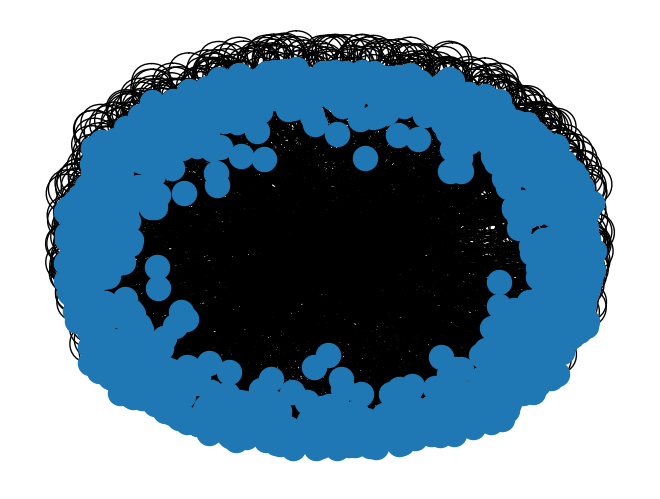

In [6]:
G = networkx.from_scipy_sparse_array(sp.io.mmread('1138_bus.mtx'))
networkx.draw(G)

In [7]:
%%bash   
make             
./main 1138_bus.bin

make: Nothing to be done for 'all'.
Seed 0: 796
Seed 1: 1137
Seed 2: 804

  1138x1 GraphBLAS double vector, full by col
  pr, 1138 entries, memory: 16.2 KB


  1138x1 GraphBLAS double vector, sparse by col
  filtered_pr, 21 entries, memory: 784 bytes

    (493,0)    0.00450512
    (496,0)    0.00173748
    (497,0)    0.00641283
    (500,0)    0.00585877
    (522,0)    0.00112799
    (529,0)    0.286987
    (568,0)    0.147624
    (570,0)    0.0538896
    (574,0)    0.187425
    (577,0)    0.00285315
    (580,0)    0.0330708
    (582,0)    0.00533416
    (774,0)    0.0538915
    (775,0)    0.00950785
    (777,0)    0.0161816
    (778,0)    0.00285315
    (779,0)    0.0072168
    (784,0)    0.0260432
    (796,0)    0.035235
    (804,0)    0.0640353
    (1137,0)    0.0368203



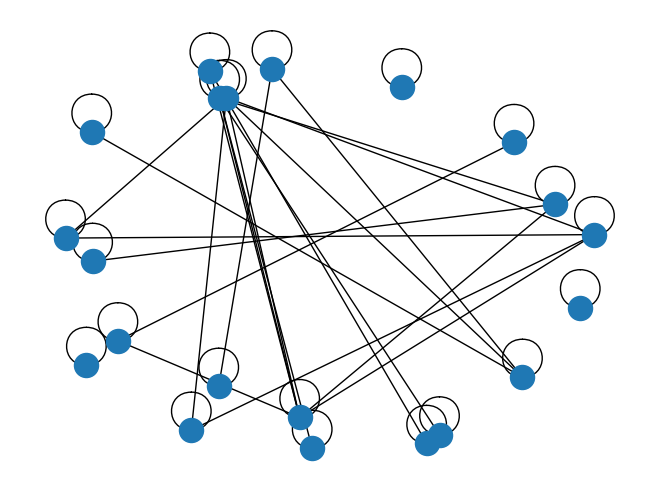

In [8]:
with open('out-list') as f:
    array = list(map(int, f.readlines()))

Gsub = networkx.subgraph(G, array)

networkx.draw(Gsub)

## More Resources

- [GraphBLAS homepage](https://graphblas.org)
  - [Great list of resources](https://graphblas.org/GraphBLAS-Pointers/)
  - [Early mathematical description](http://www.mit.edu/~kepner/GraphBLAS/GraphBLAS-Math-release.pdf)
- [LAGraph: higher level library](https://github.com/GraphBLAS/LAGraph)
  - Released v1.0 on Tuesday (20 Sep 2022), congrats!
  - Good source for more hardnened design and implementation
- [RedisGraph: property graphs built on GraphBLAS](https://redis.io/docs/stack/graph/)
- [GBTL: work towards a C++ interface and implementation](https://github.com/cmu-sei/gbtl/)